In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_ldos(i):
  return np.load(f"/bigdata/casus/wdm/Al/933K/2.699gcc/N256/ldos/Al_snapshot{i}.out.npy")

def load_snap(i):
  return np.load(f"/bigdata/casus/wdm/Al/933K/2.699gcc/N256/snap/Al_snapshot{i}.in.npy")

In [3]:
ldos = load_ldos(0)
ldos = ldos.reshape((ldos.shape[0]*ldos.shape[1]*ldos.shape[2], -1))
snap = load_snap(0)
snap = snap.reshape((snap.shape[0]*snap.shape[1]*snap.shape[2], -1))


In [4]:
n = len(ldos)
num_pairs = 10000
pairs_1 = np.random.randint(0, n, num_pairs)
pairs_2 = np.random.randint(0, n, num_pairs)
ldos_1 = ldos[pairs_1]
ldos_2 = ldos[pairs_2]
snap_1 = snap[pairs_1]
snap_2 = snap[pairs_2]

In [5]:
ldos_sim = np.sum(ldos_1 * ldos_2, axis=1)/np.sqrt(np.sum(ldos_1**2, axis=1)*np.sum(ldos_2**2, axis=1))
snap_sim = np.sum(snap_1 * snap_2, axis=1)/np.sqrt(np.sum(snap_1**2, axis=1)*np.sum(snap_2**2, axis=1))

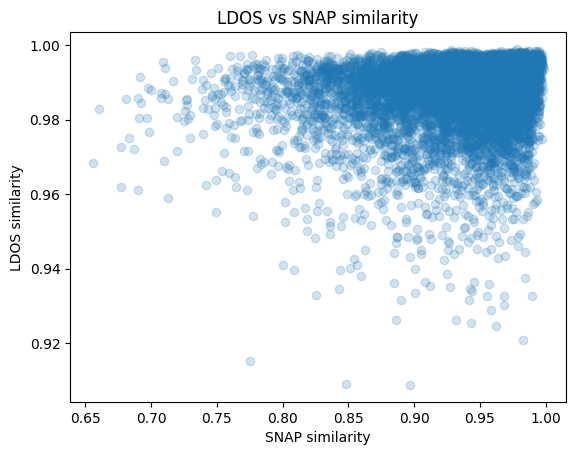

In [6]:
plt.title("LDOS vs SNAP similarity")
plt.scatter(snap_sim, ldos_sim, alpha=0.2)
plt.xlabel("SNAP similarity")
plt.ylabel("LDOS similarity")
plt.savefig("similarity.png")

In [7]:
corr = np.corrcoef(snap_sim, ldos_sim)[0, 1]
print(f"Correlation: {corr}")
print(f"R^2: {corr**2}")

Correlation: 0.18833054754976075
R^2: 0.0354683951403927


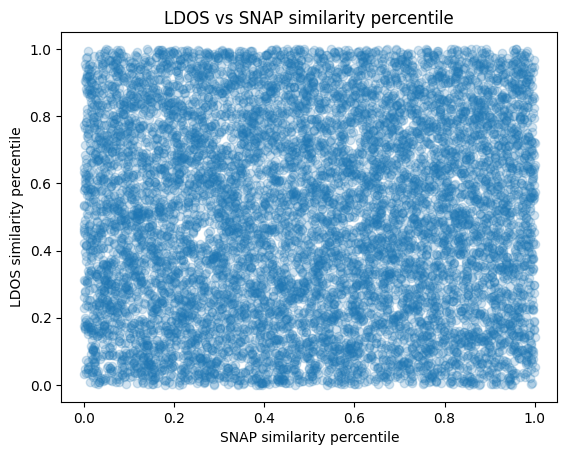

In [8]:
ldos_sim_percentile = np.argsort(ldos_sim)/len(ldos_sim)
snap_sim_percentile = np.argsort(snap_sim)/len(snap_sim)
plt.title("LDOS vs SNAP similarity percentile")
plt.scatter(snap_sim_percentile, ldos_sim_percentile, alpha=0.2)
plt.xlabel("SNAP similarity percentile")
plt.ylabel("LDOS similarity percentile")
plt.savefig("similarity_percentile.png")

In [9]:
corr = np.corrcoef(snap_sim_percentile, ldos_sim_percentile)[0, 1]
print(f"Correlation: {corr}")
print(f"R^2: {corr**2}")

Correlation: 0.01528614454486144
R^2: 0.00023366621504639716


In [10]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(ldos_1)
pca_ldos_1 = pca.transform(ldos_1)

In [11]:
pca.explained_variance_ratio_[:8].sum()

0.9696659902627947

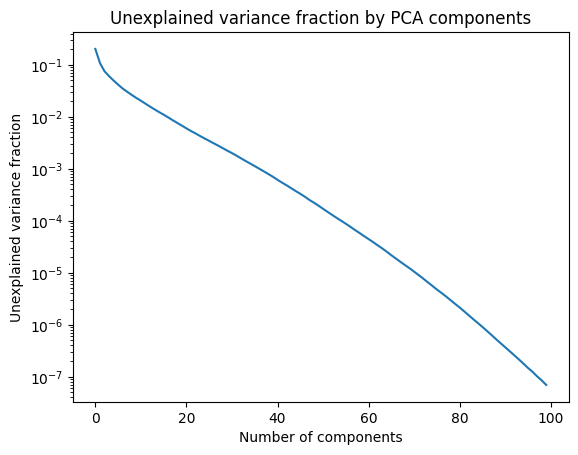

In [12]:
# Explained variance sum
plt.plot(1-np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Unexplained variance fraction")
plt.title("Unexplained variance fraction by PCA components")
# y-axis log scale
plt.yscale("log")

In [13]:
# Number of components for 99% explained variance
100 - (np.cumsum(pca.explained_variance_ratio_) > 0.99).sum() + 1

17

In [14]:
pca.explained_variance_ratio_[:17].sum()

0.9902541602702525

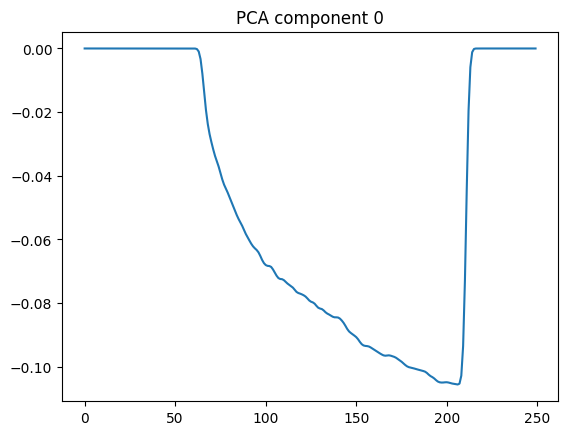

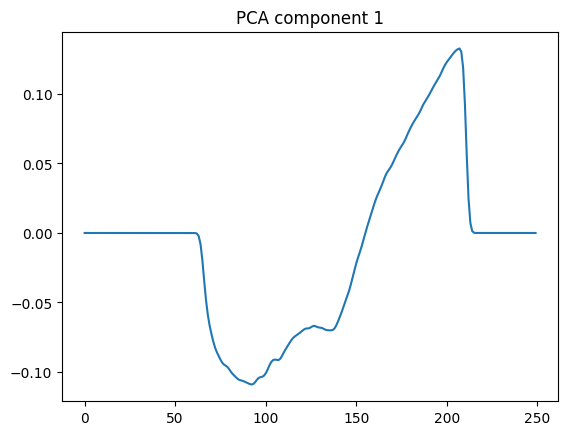

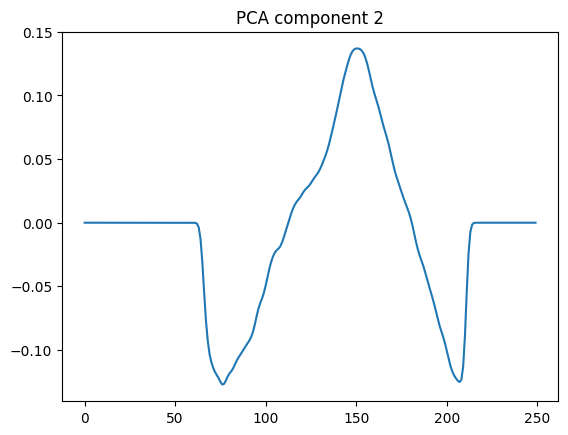

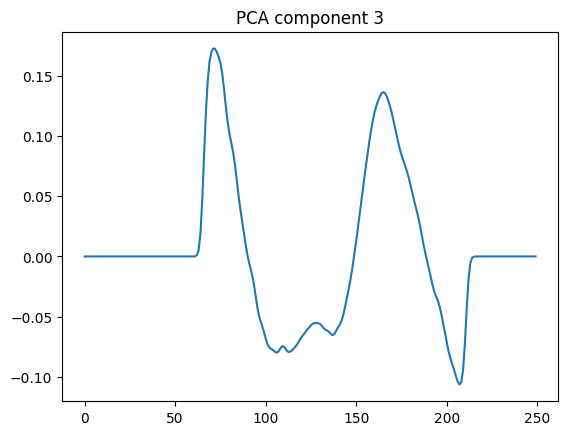

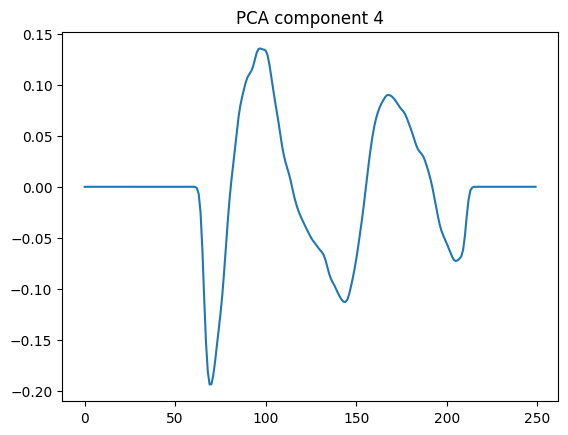

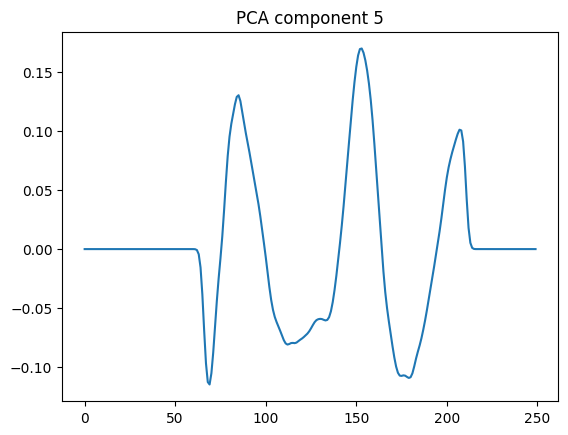

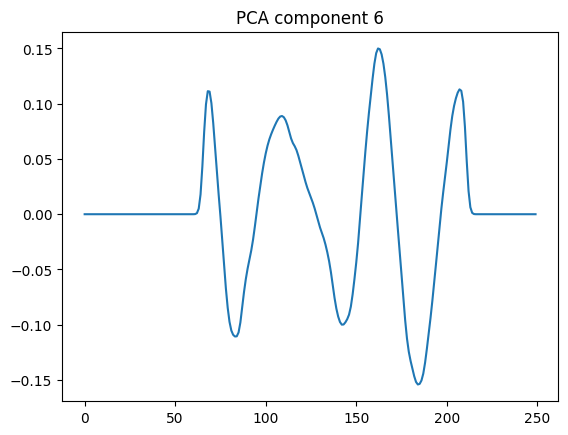

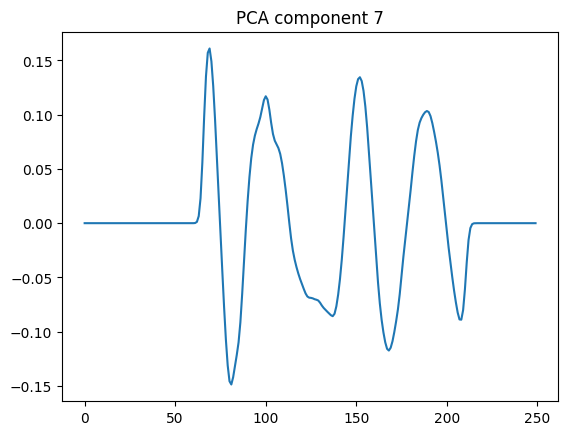

In [15]:
# Show first 8 components
for i in range(8):
  comp = pca.components_[i]
  plt.title(f"PCA component {i}")
  plt.plot(comp)
  plt.show()

Text(0, 0.5, 'SNAP similarity')

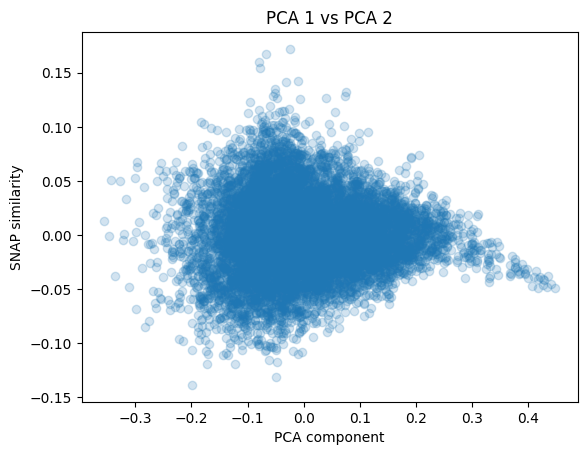

In [16]:
plt.title("PCA 1 vs PCA 2")
plt.scatter(pca_ldos_1[:, 0], pca_ldos_1[:, 1], alpha=0.2)
plt.xlabel("PCA1 component")
plt.ylabel("PCA2 similarity")

Text(0, 0.5, 'SNAP similarity')

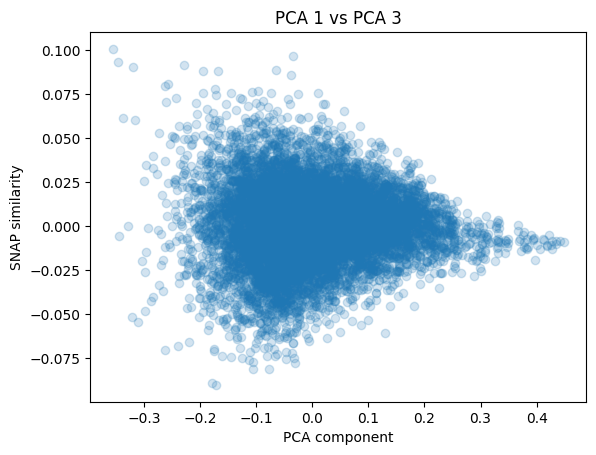

In [17]:
plt.title("PCA 1 vs PCA 3")
plt.scatter(pca_ldos_1[:, 0], pca_ldos_1[:, 2], alpha=0.2)
plt.xlabel("PCA component")
plt.ylabel("SNAP similarity")

Text(0, 0.5, 'SNAP similarity')

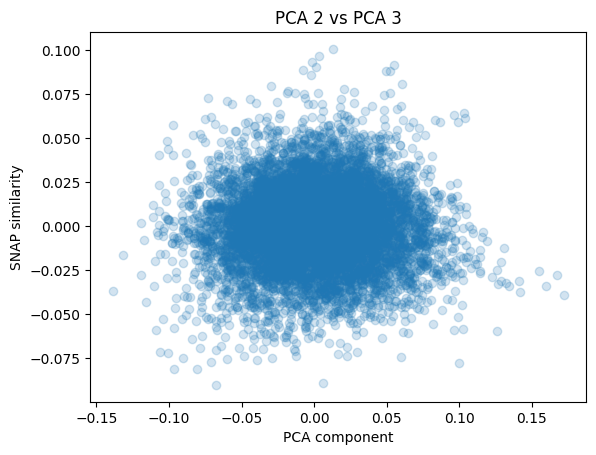

In [18]:
plt.title("PCA 2 vs PCA 3")
plt.scatter(pca_ldos_1[:, 1], pca_ldos_1[:, 2], alpha=0.2)
plt.xlabel("PCA component")
plt.ylabel("SNAP similarity")

In [19]:
# snap pca
pca_snap = PCA(n_components=50)
pca_snap.fit(snap_1)
pca_snap_1 = pca_snap.transform(snap_1)

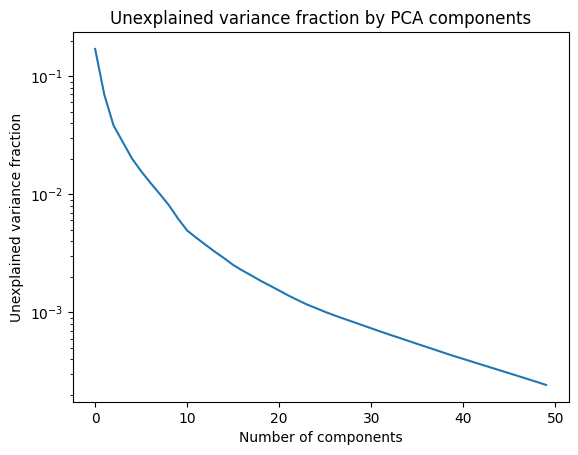

In [20]:
# Explained variance sum
plt.plot(1-np.cumsum(pca_snap.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Unexplained variance fraction")
plt.title("Unexplained variance fraction by PCA components")
# y-axis log scale
plt.yscale("log")

In [21]:
# Number of components for 99% explained variance
50 - (np.cumsum(pca_snap.explained_variance_ratio_) > 0.99).sum() + 1

9

In [22]:
pca_snap.explained_variance_ratio_[:9].sum()

0.9918944542269618

In [23]:
pca_snap.explained_variance_ratio_[:16].sum()

0.9974820208701081

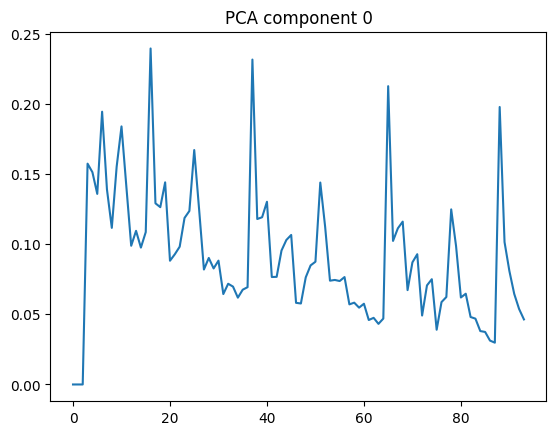

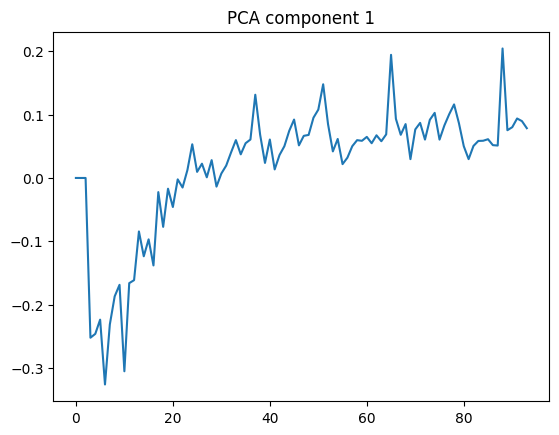

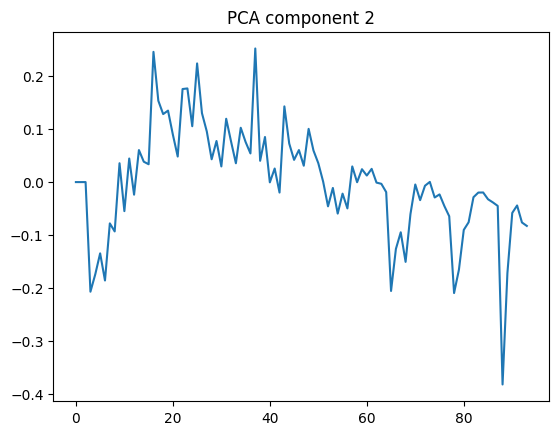

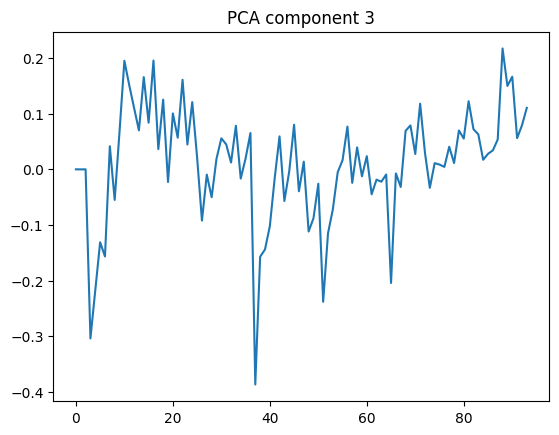

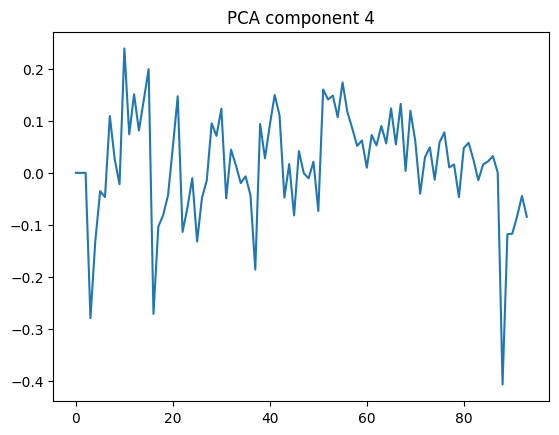

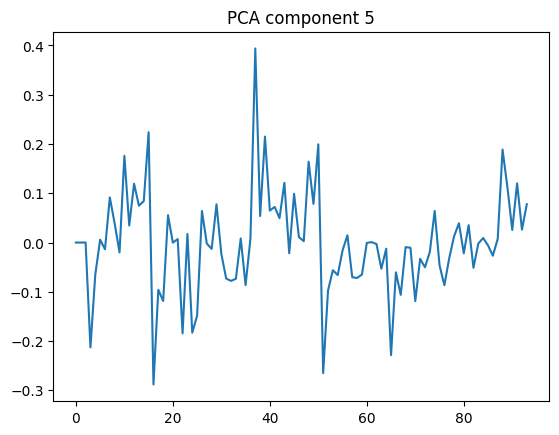

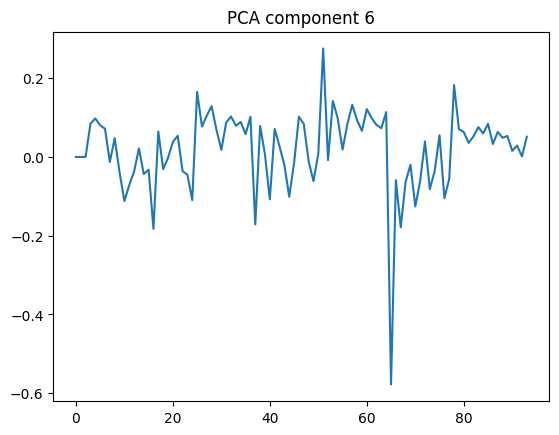

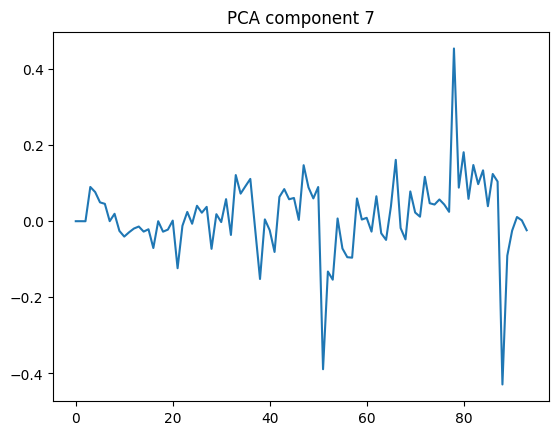

In [24]:
# Show first 8 components
for i in range(8):
  comp = pca_snap.components_[i]
  plt.title(f"PCA component {i}")
  plt.plot(comp)
  plt.show()

In [24]:
pca_snap_16 = PCA(n_components=16)
pca_snap_16.fit(snap)
snap_compressed_train = pca_snap_16.transform(snap)
snap_compressed_test  = pca_snap_16.transform(load_snap(1).reshape((snap.shape[0], -1)))

In [25]:
pca_ldos_32 = PCA(n_components=32)
pca_ldos_32.fit(ldos)
ldos_compressed_train = pca_ldos_32.transform(ldos)
ldos_compressed_test  = pca_ldos_32.transform(load_ldos(1).reshape((ldos.shape[0], -1)))

In [26]:
import torch
import pytorch_lightning as pl

In [27]:
model = torch.nn.Sequential(
  torch.nn.Linear(16, 32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 32),
  torch.nn.ReLU(),
  torch.nn.Linear(32, 32),
)

In [28]:

class PCA_LDOS_predictor(pl.LightningModule):
  def __init__(self, model):
    super().__init__()
    self.model = model
    self.loss = torch.nn.MSELoss()
  
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.001)


In [ ]:
# DataHandler pytorch lightning

In [71]:
# train with pytorch lightning
trainer = pl.Trainer(max_epochs=100, gpus=1)
model = PCA_LDOS_predictor(model)
trainer.fit(model, torch.tensor(snap_compressed_train), torch.tensor(ldos_compressed_train))


/home/brzoza73/casus/mala-venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:466: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/brzoza73/casus/mala-venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type               | Params
---------------------------------------------
0 | model | PCA_LDOS_predictor | 3.7 K 
1 | loss  | MSELoss            | 0     
---------------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

In [29]:
ldos.shape

(8000000, 250)

In [30]:
import wandb

In [35]:
wandb.init(project="ldos-snap-predictor")